# Cancellation Prediction Model

   - **Commercial Impact:** Predicting cancellations can help the hotel take proactive measures to minimize revenue loss.
   - **Data Availability:** The dataset contains relevant features such as lead_time, is_canceled, deposit_type, days_in_waiting_list, and reservation_status_date.
   - **Actionable Information:** The hotel can implement strategies like offering discounts or upgrades to guests who are likely to cancel.

In [16]:
## Import of libraries

# Standard libraries
import pandas as pd
import numpy as np

# Ploting
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Enable inline plotting
%matplotlib inline


# Sklearn related
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV,
    train_test_split
)

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Yellow Brick related
from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import (ValidationCurve, FeatureImportances)
from yellowbrick.classifier.threshold import DiscriminationThreshold
from yellowbrick.classifier import (
    ConfusionMatrix,
    ClassPredictionError,
    ClassificationReport,
    PrecisionRecallCurve,
    ROCAUC,
    ClassPredictionError
)


# For reproducibility purposes, define SEED for random_state. 
sns.set_palette("colorblind")
SEED = 42

In [17]:
# Read the dataset 
dataset_path = "../data/raw/hotel_bookings.csv"
hotel_df = pd.read_csv(dataset_path)
hotel_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [18]:
# Create downsampling
def downsample(df):
    '''
    Downsampling function
    df: Son los datos originales en forma de dataframe.
    '''
    tbl_reservations_not_cancelled = (
        df
            .query('is_canceled == 0')
            .sample(
                n = df.groupby(['is_canceled']).size()[1],
                random_state=42)
    )
    # Filtramos la clase minoritaria.
    tbl_reservations_cancelled = df.query('is_canceled == 1')

    return pd.concat([
        tbl_reservations_not_cancelled,
        tbl_reservations_cancelled
    ])

In [33]:
# hotel_df = hotel_df.drop_duplicates()
downsampled_data = downsample(hotel_df)
(downsampled_data
     .groupby(['is_canceled'])
     .size()
     .reset_index(name = 'n_reservaciones')
     .assign(pct = lambda df_: df_.n_reservaciones / df_.n_reservaciones.sum() * 100)
     .round(1)
)

,is_canceled,n_reservaciones,pct
0,0,24025,50.0
1,1,24025,50.0


In [34]:
from sklearn.model_selection import train_test_split


y = downsampled_data.is_canceled
X = downsampled_data.drop(columns = 'is_canceled')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=X_test.shape[0],
    random_state=SEED,
    stratify=y_train
)

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

variable_selection_numeric = ['arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights']
variable_selection_categoric = ['customer_type','deposit_type']               # <--- Selecciona las variable categóricas

def prep_for_ml(tbl_train, tbl_val, tbl_test, variable_selection_numeric, variable_selection_categoric, scaled:bool = False):
    '''Clean X_train and X_test
        1) Select continuous and categorical variables.
        2) Convert categorical variables to one hot encoding
        3) Concatenate clean dataframes
    '''
    # Continuous variables
    tbl_num_train = tbl_train.loc[:, variable_selection_numeric]
    tbl_num_val = tbl_val.loc[:, variable_selection_numeric]
    tbl_num_test = tbl_test.loc[:, variable_selection_numeric]

    if scaled is True:
        train_scaled = StandardScaler().fit_transform(tbl_num_train)
        val_scaled = StandardScaler().fit_transform(tbl_num_val)
        test_scaled = StandardScaler().fit_transform(tbl_num_test)

        tbl_num_train = pd.DataFrame(train_scaled, columns=tbl_num_train.columns)
        val_scaled = pd.DataFrame(val_scaled, columns=tbl_num_val.columns)
        test_scaled = pd.DataFrame(test_scaled, columns=tbl_num_test.columns)


    # Categorical variables
    tbl_cat_train = tbl_train.loc[:, variable_selection_categoric]
    tbl_cat_val = tbl_val.loc[:, variable_selection_categoric]
    tbl_cat_test = tbl_test.loc[:, variable_selection_categoric]

    ohe = OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output=False)
    ohe.fit(tbl_cat_train)
    col_names = ohe.get_feature_names_out()

    tbl_ohe_cat_train = pd.DataFrame(
        ohe.transform( tbl_cat_train )
    )

    tbl_ohe_cat_val = pd.DataFrame(
        ohe.transform( tbl_cat_val )
    )

    tbl_ohe_cat_test = pd.DataFrame(
        ohe.transform( tbl_cat_test )
    )
    # Add new column names
    tbl_ohe_cat_train.columns = col_names
    tbl_ohe_cat_val.columns = col_names
    tbl_ohe_cat_test.columns = col_names

    # Join transformed continuous + categorical variables
    tbl_train_clean = pd.concat([tbl_num_train.reset_index(drop = True), tbl_ohe_cat_train], axis = 1)
    tbl_val_clean = pd.concat([tbl_num_val.reset_index(drop = True), tbl_ohe_cat_val], axis = 1)
    tbl_test_clean = pd.concat([tbl_num_test.reset_index(drop = True), tbl_ohe_cat_test], axis = 1)

    return (tbl_train_clean, tbl_val_clean, tbl_test_clean)

In [22]:
compare_results = pd.DataFrame(columns=['model','auc','score','precision','recall'])
compare_results

,model,auc,score,precision,recall


In [23]:
def get_model_insight(
    model_name,
    clf,
    variable_selection_numeric,
    variable_selection_categoric,
    compare_results,
    scaled: bool = False,
):
    if not variable_selection_numeric:
        variable_selection_numeric = ['arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights']

    if not variable_selection_categoric:
        variable_selection_categoric = ['customer_type','deposit_type']

    X_train_clean, X_val_clean, X_test_clean = prep_for_ml(
        X_train,
        X_val,
        X_test,
        variable_selection_numeric,
        variable_selection_categoric,
        scaled
    )

    clf_model = clf.fit( X_train_clean, y_train )
    predictions = clf_model.predict(X_test_clean)

    res = {
        'model': model_name,
        'auc': roc_auc_score(y_test, predictions),
        'score': f1_score(y_test, predictions) ,
        'precision': precision_score(y_test, predictions),
        'recall': recall_score(y_test, predictions)
        }

    results = pd.DataFrame(res, index=[compare_results.shape[0]])

    compare_results = pd.concat([compare_results,results])

    display(compare_results)

    cm = ConfusionMatrix(
        clf,
        classes=['not cancelled','cancelled']
    )
    cm.fit(X_train_clean, y_train)
    cm.score(X_val_clean, y_val)
    cm.show()

    return clf_model, compare_results

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all

,model,auc,score,precision,recall
0,"Random Forest c/ 8 num, 5 cat",0.724037,0.720666,0.729580,0.711967
1,"Random Forest c/ 8 num, 5 cat, best params {'n...",0.738085,0.735581,0.742681,0.728616
2,"Random Forest c/ 8 num, 5 cat, best params {'n...",0.735692,0.731671,0.742974,0.720708
3,"Random Forest c/ 8 num, 5 cat",0.724037,0.720666,0.729580,0.711967


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



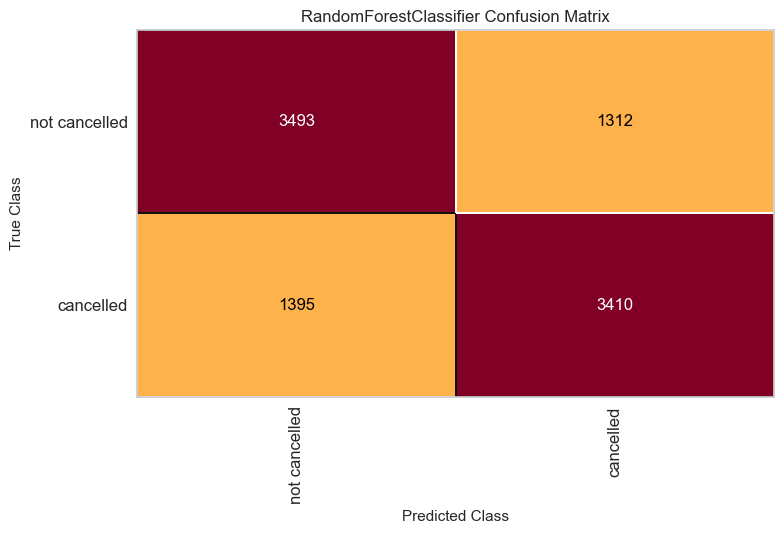

In [35]:
variable_selection_numeric = [
    'arrival_date_week_number',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'lead_time',
    'total_of_special_requests',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
]
variable_selection_categoric = [
    'hotel',
    'market_segment',
    'deposit_type',
    'customer_type',
    'meal'
]

X_train_clean, X_val_clean, X_test_clean = prep_for_ml(
        X_train,
        X_val,
        X_test,
        variable_selection_numeric,
        variable_selection_categoric,
)

rfc_w_8num_5cat, compare_results = get_model_insight(
    'Random Forest c/ 8 num, 5 cat',
    RandomForestClassifier(random_state=SEED),
    variable_selection_numeric,
    variable_selection_categoric,
    compare_results,
)

In [36]:
# Especificamos el diccionario de parámetros a partir del analisis anterior
params = {
    'n_estimators': [*range(100,120,5)],
    'max_depth': [5, 8, 15, 25],
    'min_samples_split':[*range(2,5,1)],
    'min_samples_leaf' : [2],
    'max_features' : ['log2', 'sqrt'],
}

grid_search = RandomizedSearchCV(
    RandomForestClassifier(),
    scoring = 'roc_auc',
    param_distributions = params,
    random_state = SEED,
    cv=10,
    return_train_score=True,
)

grid_search.fit(X_train_clean, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [5, 8, 15, 25],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 105, 110, 115]},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [38]:
df_best_params = pd.DataFrame(grid_search.cv_results_)
cm = sns.diverging_palette(5, 250, as_cmap=True)
pd.concat([
    df_best_params['params'].apply(pd.Series),
    df_best_params[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
    axis = 1
).sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,mean_train_score,mean_test_score,rank_test_score
3,110,4,2,sqrt,25,0.937173,0.806334,1
1,105,3,2,log2,25,0.937183,0.806119,2
5,115,3,2,log2,25,0.937613,0.805909,3
2,105,2,2,log2,25,0.936672,0.805836,4
0,100,4,2,log2,25,0.937012,0.805490,5
6,105,4,2,sqrt,15,0.858479,0.804926,6
7,110,3,2,sqrt,8,0.802566,0.793312,7
4,105,4,2,log2,8,0.802776,0.793098,8
8,100,2,2,log2,5,0.786749,0.783231,9
9,110,4,2,log2,5,0.786365,0.782955,10


,model,auc,score,precision,recall
0,"Random Forest c/ 8 num, 5 cat",0.724037,0.720666,0.729580,0.711967
1,"Random Forest c/ 8 num, 5 cat, best params {'n...",0.738085,0.735581,0.742681,0.728616
2,"Random Forest c/ 8 num, 5 cat, best params {'n...",0.735692,0.731671,0.742974,0.720708
3,"Random Forest c/ 8 num, 5 cat",0.724037,0.720666,0.729580,0.711967
4,"Random Forest c/ 8 num, 5 cat, best params {'n...",0.736941,0.735510,0.739533,0.731530


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



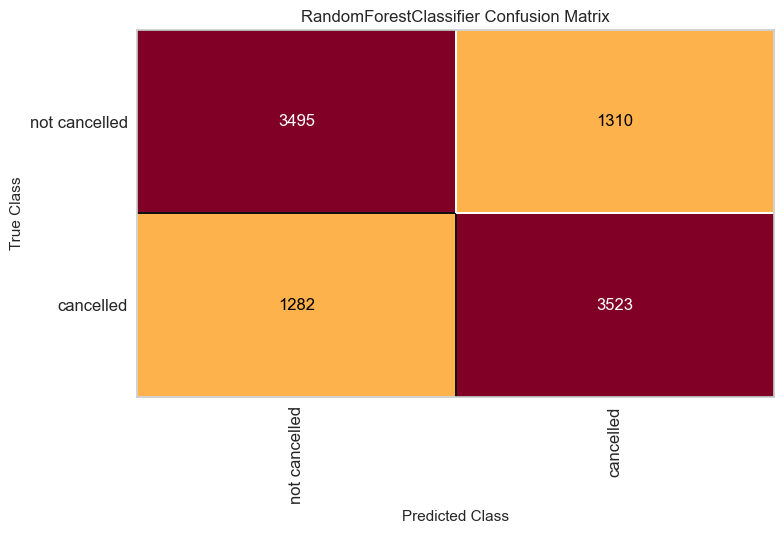

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [39]:
best_model_RFC = grid_search.best_estimator_
clf_model = best_model_RFC.fit( X_train_clean, y_train )
predictions = clf_model.predict(X_test_clean)
res = {
    'model': f"Random Forest c/ 8 num, 5 cat, best params {grid_search.best_params_}",
    'auc': roc_auc_score(y_test, predictions),
    'score': f1_score(y_test, predictions) ,
    'precision': precision_score(y_test, predictions),
    'recall': recall_score(y_test, predictions)
    }

results = pd.DataFrame(res, index=[compare_results.shape[0]])

compare_results = pd.concat([compare_results,results])

display(compare_results)

cm = ConfusionMatrix(
    best_model_RFC,
    classes=['not cancelled','cancelled']
)
cm.fit(X_train_clean, y_train)
cm.score(X_val_clean, y_val)
cm.show()

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



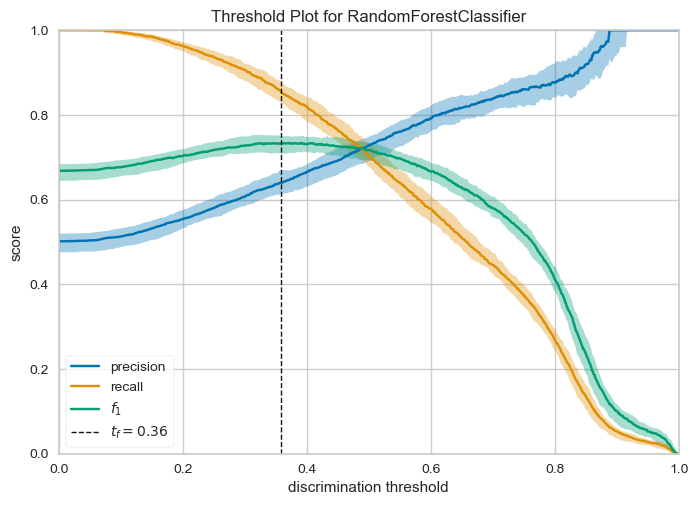

In [31]:
from yellowbrick.classifier.threshold import DiscriminationThreshold
# Especificamos la gráfica
visualizer = DiscriminationThreshold(
	best_model_RFC,							# Pasar el estimador del mejor modelo que
    									# se obtiene de la validación cruzada.
	exclude = ["queue_rate"]			# Excluimos de la gráfica algunas métricas
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_val_clean, y_val)
# Dibjuamos la visualización.
visualizer.show()

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



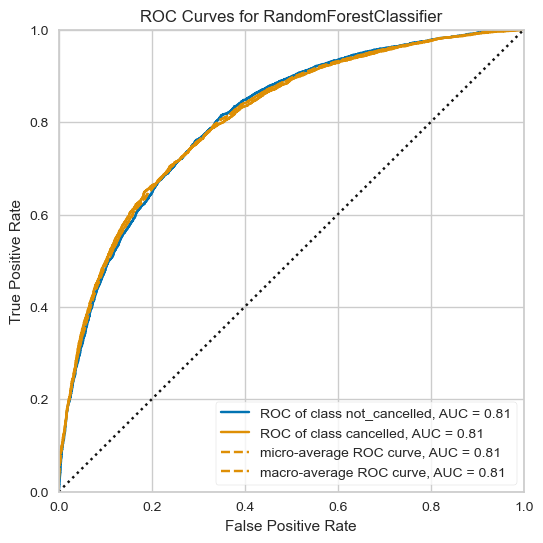

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [37]:
from yellowbrick.classifier import ROCAUC
# Especificamos la curva ROC AUC
fig, ax = plt.subplots(figsize = (6,6))
roc_curves_visualizer = ROCAUC(
    best_model_RFC,
    classes=['not_cancelled', 'cancelled']
)

# Ajustamos la visualización a los datos de entrenamiento
roc_curves_visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
roc_curves_visualizer.score(X_val_clean, y_val)
# Dibjuamos la visualización.
roc_curves_visualizer.show()